In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from linearmodels.iv import IV2SLS

In [67]:
data = pd.read_stata('africa.dta')
data.head()

,x,y,group,xc,yc,center,distance,part,cap,income
0,65.247635,68.470764,1.0,60.993904,71.246994,25.0,5.079537,15.686678,92.124344,135.682449
1,17.112789,55.649460,3.0,17.800810,51.957294,40.0,3.755725,12.932481,138.966156,140.656082
2,53.541748,19.327223,3.0,48.068378,19.055309,42.0,5.480121,14.311936,88.882370,146.201965
3,64.877892,33.090942,1.0,65.107460,32.802567,7.0,0.368594,19.091896,91.726250,167.282196
4,67.073807,64.514954,1.0,60.993904,71.246994,25.0,9.071142,15.176675,71.116608,149.815842


**1. Data preparation**

In [68]:
summary = data.describe()
summary

,x,y,group,xc,yc,center,distance,part,cap,income
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,48.529327,48.443504,2.029500,49.004665,47.647854,26.943501,7.342320,11.447350,102.324600,137.250000
std,27.861746,24.511271,0.818513,28.319460,23.931879,14.484354,3.531068,4.191597,24.985056,18.774225
min,0.153942,0.006010,1.000000,0.884082,2.240541,1.000000,0.203446,0.000000,19.197878,57.170677
25%,21.766729,28.263509,1.000000,26.015562,25.541374,13.000000,4.681370,8.776036,86.046284,125.027357
50%,51.351805,50.708405,2.000000,50.649651,51.957294,31.000000,7.153416,11.856450,102.832863,137.018074
75%,72.799995,65.635342,3.000000,78.337456,63.367405,40.000000,9.624988,14.204031,119.080307,150.063194
max,106.602692,99.999565,3.000000,99.887405,99.397995,50.000000,23.262558,22.950117,177.980835,204.630173


In [69]:
variables = ['x', 'y', 'group', 'xc', 'yc', 'center', 'distance', 'part', 'cap', 'income']

missing_values = data[variables].isnull().sum()
print("Missing values for each variable:")
print(missing_values)

Q1 = data[variables].quantile(0.25)
Q3 = data[variables].quantile(0.75)
IQR = Q3 - Q1

outliers = ((data[variables] < (Q1 - 1.5 * IQR)) | (data[variables] > (Q3 + 1.5 * IQR))).sum()
print("\nOutliers for each variable:")
print(outliers)

Missing values for each variable:
x           0
y           0
group       0
xc          0
yc          0
center      0
distance    0
part        0
cap         0
income      0
dtype: int64

Outliers for each variable:
x            0
y            0
group        0
xc           0
yc           0
center       0
distance    12
part        24
cap         18
income      13
dtype: int64


There are no missing values in the data. There are however some outliers which are inspected below.

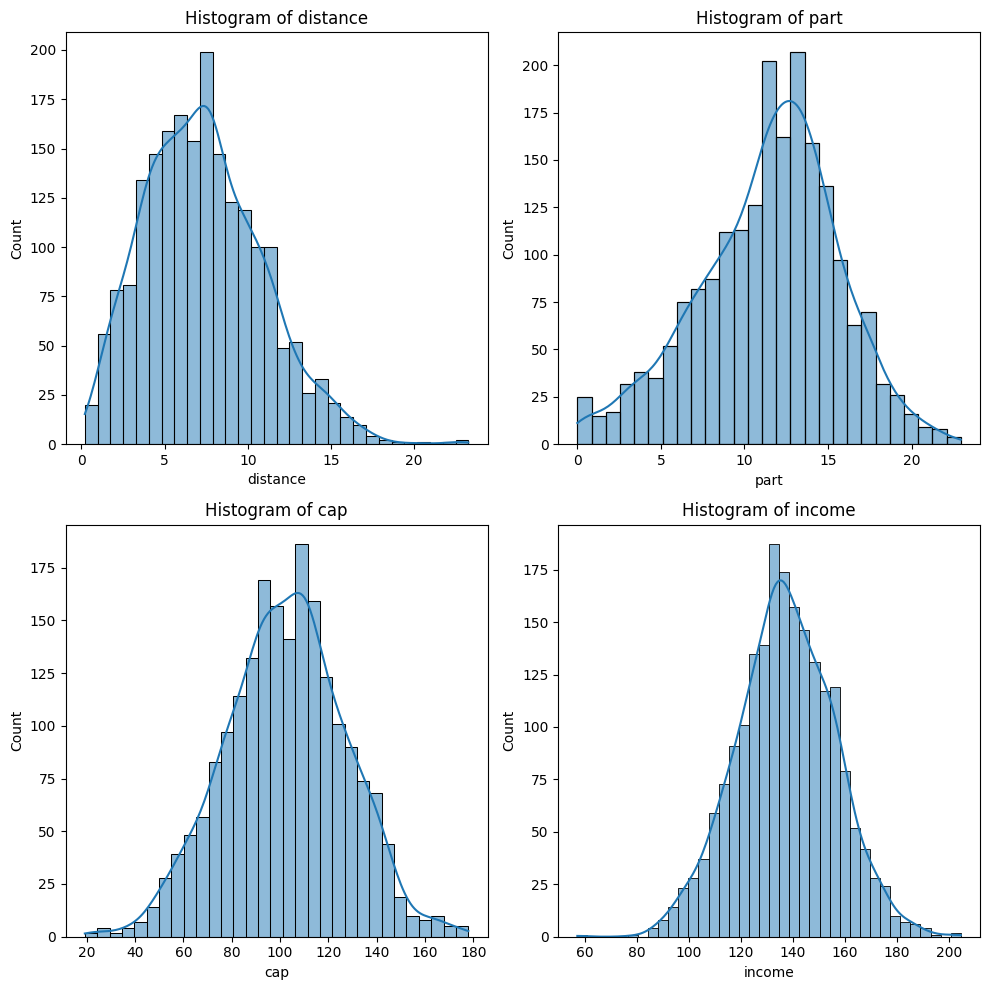

In [70]:
variables = ['distance', 'part', 'cap', 'income']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for var, ax in zip(variables, axs.flatten()):
    sns.histplot(data[var], kde=True, ax=ax)
    ax.set_title('Histogram of ' + var)

plt.tight_layout()
plt.show()

The histograms show the distribution of the variables with outliers. The distributions look pretty normal and there don't seem to be any extreme outliers.

In [80]:
dependent = data['income']
endog = data['part']
exog = pd.DataFrame(np.ones(len(data)), columns=['Intercept'])
instrument = data['distance']

iv = IV2SLS(dependent, exog, endog, instrument)
results = iv.fit()

results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                 income   R-squared:                      0.0725
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0720
No. Observations:                2000   F-statistic:                    5.8548
Date:                Tue, Dec 19 2023   P-value (F-stat)                0.0155
Time:                        10:01:19   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      132.46     2.0203     65.563     0.0000      128.50      136.41
part           0.4189     0.1731     2.4197     0.0155      0.0796      0.7581
==============================================================================

Endogenous: part
Instruments: distance
Robust Covariance (Heteroskedastic)
Debiased: False
"""

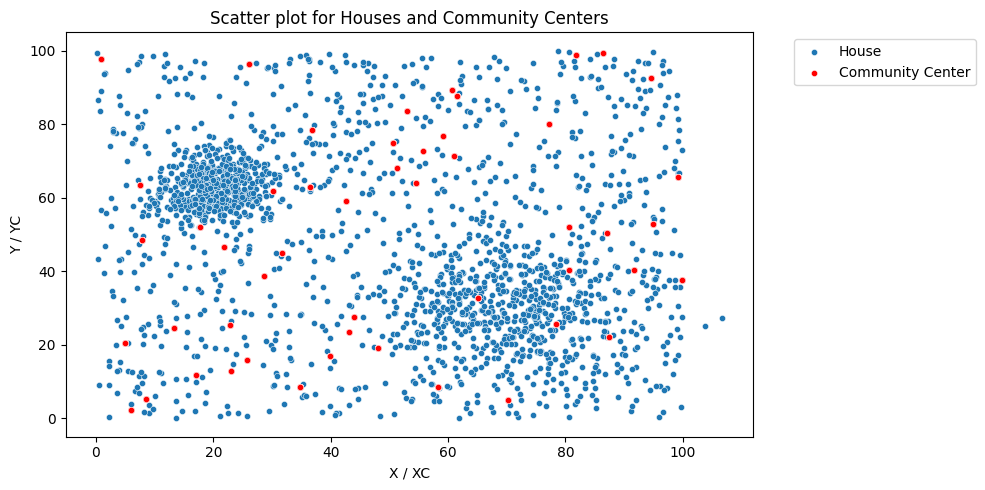

In [72]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(x='x', y='y', data=data, ax=ax, s=20, label='House')

sns.scatterplot(x='xc', y='yc', data=data, ax=ax, color='red', s=20, label='Community Center')

ax.set_title('Scatter plot for Houses and Community Centers')
ax.set_xlabel('X / XC')
ax.set_ylabel('Y / YC')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

The scatterplot shows houses and community centers distributed seemingly at random. This randomness supports the exclusion restriction in our IV regression, as it suggests that the distance to community centers (our instrument) likely affects income (dependent variable) primarily through its influence on participation in community activities (endogenous variable), rather than having a direct effect on income.

In [73]:
data_means = data.groupby('center')[['income', 'part', 'distance']].mean().reset_index()
data_means.columns = ['center', 'mean_income', 'mean_part', 'mean_dist']

data = pd.merge(data, data_means, on='center', how='left')

data

,x,y,group,xc,yc,center,distance,part,cap,income,mean_income,mean_part,mean_dist
0,65.247635,68.470764,1.0,60.993904,71.246994,25.0,5.079537,15.686678,92.124344,135.682449,145.051498,14.844684,6.689123
1,17.112789,55.649460,3.0,17.800810,51.957294,40.0,3.755725,12.932481,138.966156,140.656082,133.873657,9.626195,6.493014
2,53.541748,19.327223,3.0,48.068378,19.055309,42.0,5.480121,14.311936,88.882370,146.201965,134.714706,11.382967,6.852208
3,64.877892,33.090942,1.0,65.107460,32.802567,7.0,0.368594,19.091896,91.726250,167.282196,142.964828,13.589553,7.237815
4,67.073807,64.514954,1.0,60.993904,71.246994,25.0,9.071142,15.176675,71.116608,149.815842,145.051498,14.844684,6.689123
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,17.723021,28.441809,3.0,13.377138,24.468124,32.0,5.888706,13.340007,122.478485,127.514351,138.483704,12.441358,6.229427
1996,63.326031,35.020229,2.0,65.107460,32.802567,7.0,2.844559,13.197288,111.977600,125.312035,142.964828,13.589553,7.237815
1997,23.242783,32.175903,3.0,22.766520,25.325298,24.0,6.867140,11.282405,60.621052,108.963234,132.044388,11.318337,6.167306
1998,16.669905,78.950928,3.0,7.424784,63.367405,41.0,18.119560,0.452368,83.069824,105.777130,125.242798,6.633493,9.246074


In [79]:
dependent = data['mean_income']
exog = pd.DataFrame(np.ones(len(data)), columns=['Intercept'])
endog = data['mean_part']
instrument = data['mean_dist']

iv = IV2SLS(dependent, exog, endog, instrument)
results = iv.fit()

results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:            mean_income   R-squared:                      0.9028
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9027
No. Observations:                2000   F-statistic:                    3353.4
Date:                Tue, Dec 19 2023   P-value (F-stat)                0.0000
Time:                        10:01:04   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      107.09     0.4910     218.09     0.0000      106.13      108.05
mean_part      2.6348     0.0455     57.908     0.0000      2.5456      2.7239
==============================================================================

Endogenous: mean_part
Instruments: mean_dist
Robust Covariance (Heteroskedastic)
Debiased: False
"""

The difference in the coefficients between individuals and communities could be attributed to the collective benefits of participation. For an individual, increased participation in community activities might lead to a smaller increase in income, as the time spent volunteering could otherwise be used for income-generating work. However, when viewed from a community perspective, the scenario changes. The efforts of those who volunteer can create benefits that extend to the entire community. Even those who do not directly participate can reap the rewards of a more vibrant, cooperative, and resource-rich community. Thus, the overall impact on community income could be greater for each unit increase in participation, explaining the higher coefficient at the community level.